# Marco Lavorini   -  Assignment 3

In [430]:
import idx2numpy
import numpy as np
from matplotlib import pyplot as plt
import os



def read_idx(filename):
    array = idx2numpy.convert_from_file(filename)
    return array

files = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte"]

x_train = read_idx(os.path.join("..", "datasets", "mnist", files[0]))
y_train = read_idx(os.path.join("..", "datasets", "mnist", files[1]))
x_test = read_idx(os.path.join("..", "datasets", "mnist", files[2]))
y_test = read_idx(os.path.join("..", "datasets", "mnist", files[3]))

print(y_train)


[5 0 4 ... 5 6 8]


In [440]:
x_train_b = np.where(x_train > 0, 1, 0)
x_test_b = np.where(x_test > 0, 1, 0)

x_train_b = x_train/255
x_test_b = x_test/255


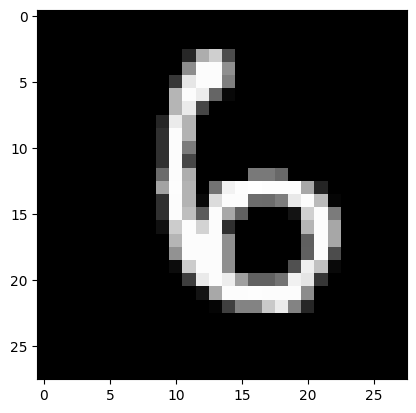

In [441]:
#print first element in data using matplot lib
plt.imshow(x_train_b[186], cmap='gray')
plt.show()

# Sigmoid function

In [442]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [473]:
from tqdm import tqdm

class rbm:
    def __init__(self, num_visible, num_hidden):
        self.h = num_hidden
        self.v = num_visible
        self.W = np.random.uniform(-0.05, 0.05, (num_visible, num_hidden))
        self.bh = np.zeros(num_hidden)
        self.bv = np.zeros(num_visible)
    
    def fit(self, X, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        

        for epoch in tqdm(range(epochs)):
            err=[]
            for data in X:
                # wake part
                #print('wake')
                pos_def_P = sigmoid(np.dot(data.T, self.W) + self.bh)

                #print(f'pos_def_P shape: {pos_def_P.shape}')
                #print(f'max pos_def_P: {np.max(pos_def_P)}')
                #print(f'max X: {np.max(data)}')
                
                wake = np.dot(data, pos_def_P)
                #print(wake)
                #print(f'\n\n(max wake: {np.max(wake)}\n\n')
            
                #print('dream')
                # dream part
                pos_hid_S = pos_def_P > np.random.rand(self.h) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(self.v)
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                #print(dream)
                #check
                err.append(np.sum(data - recon_data)**2)   #check  
            

                deltaW = (wake - dream)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))
                deltaBv = (np.sum(data) - np.sum(recon_data))
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv
            #print(f'epoch: {epoch}, err: {np.mean(err)}, len err: {len(err)}')

    def reconstruct(self, X):
        hidden = sigmoid(np.dot(X.T, self.W) + self.bh)
        reconstructed = sigmoid(np.dot(hidden, self.W.T) + self.bv)
        return reconstructed

# valutare di samplare su distribuzioni gausssiane per vl aleatoria non binaria 

# valutare cd_k

In [468]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[0].flatten().shape)

(60000, 28, 28)
(28, 28)
(784,)


In [469]:

x_train_flattened = x_train_b.reshape(x_train_b.shape[0], -1, 1)
print(x_train_flattened.shape)
print(y_train.shape)

(60000, 784, 1)
(60000,)


In [470]:
print(f'max: {np.max(x_train_flattened[0])}')

max: 1.0


In [520]:
net = rbm(x_train_flattened.shape[1], 512)
print(f'v = {net.v}')
print(f'h = {net.h}')

v = 784
h = 512


In [521]:
net.fit(x_train_flattened[:500], epochs=25, lr=0.01, batch_size=500)

todo


100%|██████████| 25/25 [02:19<00:00,  5.60s/it]


In [480]:
39308480

39308480

In [522]:
recon = net.reconstruct(x_train_flattened[4])

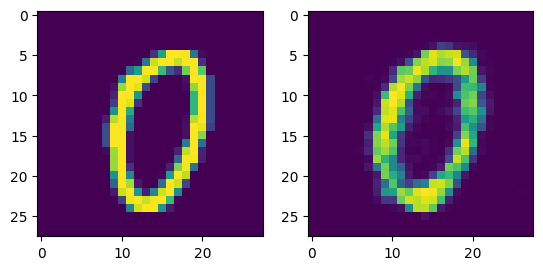

In [527]:
img = 1000

recon = net.reconstruct(x_train_flattened[img])
#plot the original by the side
plt.subplot(1, 2, 1)
plt.imshow(x_train[img].reshape(28, 28))
plt.subplot(1, 2, 2)
plt.imshow(recon.reshape(28, 28))

plt.show()